In [98]:
import torch, os
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torch.utils.data as data
import torchvision.transforms as transforms
import torchvision.models as models
import numpy as np
import random
import torch.utils.data as torchdata
from torch.utils.data import SubsetRandomSampler
from train_model import train_model
from test_model import test_model
%matplotlib inline

In [99]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]='3'

# ImageNet-tiny and Caltech-256

In [3]:
filePath = '/local/rcs/ll3504/datasets/256_ObjectCategories/'
namelist = os.listdir(filePath)
nameDic_cal = {}
for name in namelist:
    splits = name.split(".")
    nameDic_cal[int(splits[0])-1] = splits[1]
print(nameDic_cal[1])

american-flag


In [4]:
import re
fileName = '/local/rcs/ll3504/datasets/tiny-imagenet-200/words.txt'
nameDic_tiny = {}
with open(fileName, "r") as f:
    temp = f.readlines()
for i in range(len(temp)):
    splits = re.split(',|\n|\t', temp[i])
    nameDic_tiny[splits[0]] = splits[1]

In [5]:
filePath = '/local/rcs/ll3504/datasets/tiny-224/train/'
namelist = os.listdir(filePath)
namelist.sort()
nameDic_t = {}
i = 0
for name in namelist:
    if name.startswith('n'):
        nameDic_t[i] = name
        i += 1

In [6]:
nameDic_tiny_imageNet = {}
for key in nameDic_t:
    nameDic_tiny_imageNet[key] = nameDic_tiny[nameDic_t[key]]

In [7]:
common_classes = []
i = 0
for key in nameDic_tiny_imageNet:
    if nameDic_tiny_imageNet[key] in nameDic_cal.values():
        temp = str(i)+" "+str(nameDic_tiny_imageNet[key])
        common_classes.append(str(temp))
        i += 1
print(common_classes)

['0 goldfish', '1 centipede', '2 goose', '3 snail', '4 grasshopper', '5 cockroach', '6 backpack', '7 bathtub', '8 binoculars', '9 cannon', '10 hourglass', '11 refrigerator', '12 syringe', '13 teapot', '14 mushroom']


In [8]:
with open("common_classes_tinyImageNet_Caltech256.txt","w") as f:
    for common_class in common_classes:
        f.write(common_class+"\n")

In [9]:
import re
fileName = 'common_classes_tinyImageNet_Caltech256.txt'
common_classes = {}
with open(fileName, "r") as f:
    temp = f.readlines()
print(temp)
for i in range(len(temp)):
    splits = temp[i].split()
    common_classes[splits[1]] = int(splits[0])
print(common_classes)

['0 goldfish\n', '1 centipede\n', '2 goose\n', '3 snail\n', '4 grasshopper\n', '5 cockroach\n', '6 backpack\n', '7 bathtub\n', '8 binoculars\n', '9 cannon\n', '10 hourglass\n', '11 refrigerator\n', '12 syringe\n', '13 teapot\n', '14 mushroom\n']
{'goldfish': 0, 'centipede': 1, 'goose': 2, 'snail': 3, 'grasshopper': 4, 'cockroach': 5, 'backpack': 6, 'bathtub': 7, 'binoculars': 8, 'cannon': 9, 'hourglass': 10, 'refrigerator': 11, 'syringe': 12, 'teapot': 13, 'mushroom': 14}


In [10]:
data_dir = '/local/rcs/ll3504/datasets/tiny-224-common/'
num_workers = {'train': 100,'val': 100,'test': 100}
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize([256, 256]),
        transforms.RandomCrop(224),
        transforms.RandomRotation(20),
        transforms.RandomHorizontalFlip(0.5),
        transforms.ToTensor(),
        transforms.Normalize([0.4802, 0.4481, 0.3975], [0.2302, 0.2265, 0.2262]),
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.4802, 0.4481, 0.3975], [0.2302, 0.2265, 0.2262]),
    ]),
    'test': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.4802, 0.4481, 0.3975], [0.2302, 0.2265, 0.2262]),
    ])
}
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) 
                  for x in ['train', 'val','test']}
tiny_dataloaders = {x: data.DataLoader(image_datasets[x], batch_size=100, shuffle=True, num_workers=num_workers[x])
                  for x in ['train', 'val', 'test']}
tiny_dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}

/home/ll3504/anaconda3/envs/edgemonitor/lib/python3.7/site-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 100 worker processes in total. Our suggested max number of worker in current system is 80, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


# ImageClef

In [3]:
def get_dataset(path='/database', dataset_name='caltech-256-common'):
    data_transforms = {
        'train': transforms.Compose([
            transforms.Resize([256, 256]),
            transforms.RandomCrop(224),
            transforms.RandomRotation(20),
            transforms.RandomHorizontalFlip(0.5),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ]),
        'test': transforms.Compose([
            transforms.Resize([224, 224]),
            transforms.CenterCrop((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    }

    tr_dataset = datasets.ImageFolder(path + dataset_name + '/', data_transforms['train'])
    te_dataset = datasets.ImageFolder(path + dataset_name + '/', data_transforms['test'])
    print('{} train set size: {}'.format(dataset_name, len(tr_dataset)))
    print('{} test set size: {}'.format(dataset_name, len(te_dataset)))

    return tr_dataset, te_dataset

In [4]:
def split_dataset(train_dataset, test_dataset, valid_size=0.2, batch_size=128):
    num_train = len(train_dataset)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))
    random.shuffle(indices)
    train_idx, valid_idx, test_idx = indices[split*2:], indices[:split], indices[split:split*2]
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)
    test_sampler = SubsetRandomSampler(test_idx)

    train_loader = torchdata.DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=batch_size, pin_memory=True, drop_last=True, sampler = train_sampler)
    val_loader = torchdata.DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=batch_size, pin_memory=True, drop_last=True, sampler = train_sampler)
    test_loader = torchdata.DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=batch_size, pin_memory=True, drop_last=True, sampler = test_sampler)
    dataloaders = {'train': train_loader,
                   'val': val_loader,
                   'test': test_loader}
    dataset_sizes ={'train': int(np.floor((1-valid_size*2) * num_train)),
                    'val': int(np.floor(valid_size * num_train)),
                    'test': int(np.floor(valid_size * num_train))}
    return dataloaders, dataset_sizes

In [5]:
imagebase = '/local/rcs/ll3504/datasets/'

In [6]:
pascal_train_images, pascal_test_images = get_dataset(imagebase, 'image_CLEF/pascal')
pascal_dataloaders, pascal_dataset_sizes = split_dataset(pascal_train_images, pascal_test_images, 0.2, 30)

image_CLEF/pascal train set size: 600
image_CLEF/pascal test set size: 600


In [7]:
bing_train_images, bing_test_images = get_dataset(imagebase, 'image_CLEF/bing')
bing_dataloaders, bing_dataset_sizes = split_dataset(bing_train_images, bing_test_images, 0.2, 30)

image_CLEF/bing train set size: 600
image_CLEF/bing test set size: 600


In [8]:
imagenet_train_images, imagenet_test_images = get_dataset(imagebase, 'image_CLEF/imagenet')
imagenet_dataloaders, imagenet_dataset_sizes = split_dataset(imagenet_train_images, imagenet_test_images, 0.2, 30)

image_CLEF/imagenet train set size: 600
image_CLEF/imagenet test set size: 600


In [9]:
caltech_train_images, caltech_test_images = get_dataset(imagebase, 'image_CLEF/caltech')
caltech_dataloaders, caltech_dataset_sizes = split_dataset(caltech_train_images, caltech_test_images, 0.2, 30)

image_CLEF/caltech train set size: 600
image_CLEF/caltech test set size: 600


In [10]:
#Load Resnet50
model_ft = models.resnet50(True)
#Finetune Final few layers to adjust for tiny imagenet input
model_ft.avgpool = nn.AdaptiveAvgPool2d(1)
model_ft.fc.out_features = 15
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_ft = model_ft.to(device)

#Loss Function
criterion = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

In [11]:
#Train
train_model("imageclef-caltech-224", model_ft, caltech_dataloaders, caltech_dataset_sizes, criterion, optimizer_ft, num_epochs=10)

Epoch 1/10
----------


Exception ignored in: <function _releaseLock at 0x7fd62c4b6560>
Traceback (most recent call last):
  File "/home/ll3504/anaconda3/envs/edgemonitor/lib/python3.7/logging/__init__.py", line 221, in _releaseLock
    def _releaseLock():
KeyboardInterrupt


RuntimeError: DataLoader worker (pid(s) 24222, 24270, 24318, 24366, 24414, 24462, 24510, 24558, 24606, 24655, 24703, 24751, 24799, 24847, 24896, 24944, 24992, 25040, 25089, 25137, 25185, 25233, 25281, 25329, 25377, 25425, 25473, 25521, 25572, 25621, 25669, 25717, 25765, 25814, 25862, 25911, 25960, 26008, 26056) exited unexpectedly

In [51]:
# model_ft.load_state_dict(torch.load('./models/model_6_epoch.pt'))
# #Test
# test_model(model_ft, dataloaders, dataset_sizes, criterion, optimizer_ft)

### Evaluate models

In [10]:
#Test Resnet50-224
model_clef = models.resnet50()
#Finetune Final few layers to adjust for tiny imagenet input
model_clef.avgpool = nn.AdaptiveAvgPool2d(1)
model_clef.fc.out_features = 12
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_clef.load_state_dict(torch.load('models/imageclef-imagenet-224/model_6_epoch.pt'))
model_clef = model_clef.to(device)

#Loss Function
criterion = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

NameError: name 'model' is not defined

In [ ]:
#Test
test_model(model_clef, pascal_dataloaders, pascal_dataset_sizes, criterion, optimizer)

In [ ]:
test_model(model_clef, imagenet_dataloaders, imagenet_dataset_sizes, criterion, optimizer)

In [ ]:
test_model(model_clef, bing_dataloaders, bing_dataset_sizes, criterion, optimizer)

In [ ]:
test_model(model_clef, caltech_dataloaders, caltech_dataset_sizes, criterion, optimizer)

### Drift Detection

In [6]:
from utils.drift_detection import drift_detection
from utils.k_means import kmeans
from timeit import default_timer as timer
from sklearn.decomposition import PCA
from scipy.stats import entropy
from scipy.special import softmax
from scipy.stats import chi2_contingency, ks_2samp, entropy
import torch

In [7]:
def get_result(model, dataloaders, dataset='test', threshold=0.0):
    data = []
    labels = []
    uncertainties = []
    accuracys = []
    new_uncertainties = []
    new_labels = []
    new_predicts = []
    for x, label in dataloaders[dataset]:
        x = x.cuda()
        label = label.cuda()
        x = model(x)
        _, predicted = torch.max(x, 1)
        x = x.cpu().detach().numpy()
        uncertainty = entropy(softmax(x, axis=-1), axis=-1)
        uncertainty = np.array(uncertainty)
        index = np.array(uncertainty>threshold, dtype='bool')
        label = label.cpu().detach().numpy()
        predicted = predicted.cpu().detach().numpy()
        filtered_uncertainty = uncertainty[index]
        filtered_label = label[index]
        filtered_predicts = predicted[index]
        new_uncertainties += list(filtered_uncertainty)
        new_labels += list(filtered_label)
        new_predicts += list(filtered_predicts)
        size = label.shape[0]
    
    for i in range(int(len(new_uncertainties)/size)):
        uncertainty = np.array(new_uncertainties[i*size:(i+1)*size])
        label = np.array(new_labels[i*size:(i+1)*size])
        predict =  np.array(new_predicts[i*size:(i+1)*size])
        correct = (predict == label).sum().item()
        accuracy = correct/size
        data.append(x)
        labels.append(label)
        uncertainties.append(uncertainty)
        accuracys.append(accuracy)
    return data, labels, uncertainties, accuracys

In [8]:
def process_data(data, labels):
    new_data = []
    new_labels = []
    for batch in data:
        for i in batch:
            new_data.append(i)
    for batch in labels:
        for i in batch:
            new_labels.append(i)
    return new_data, new_labels

In [14]:
i_x, i_y, i_uncertainties, i_acc = get_result(model_clef, imagenet_dataloaders)
i_x_processed, i_y_processed = process_data(i_x, i_y)

In [15]:
b_x, b_y, b_uncertainties, b_acc = get_result(model_clef, bing_dataloaders)
b_x_processed, b_y_processed = process_data(b_x, b_y)

In [16]:
p_x, p_y, p_uncertainties, p_acc = get_result(model_clef, pascal_dataloaders)
p_x_processed, p_y_processed = process_data(p_x, p_y)

In [17]:
c_x, c_y, c_uncertainties, c_acc = get_result(model_clef, caltech_dataloaders)
c_x_processed, c_y_processed = process_data(c_x, c_y)

In [43]:
detector = drift_detection(b_x_processed,  .05, 'KSDrift')

In [23]:
print('bing: ')
preds = detector.get_result(b_x_processed)
labels = ['No!', 'Yes!']
flag = preds['is_drift']
print('Drift? {}'.format(labels[flag]))
print('Feature-wise p-values:')
print(preds['p_val'])

bing: 
Drift? No!
Feature-wise p-values:
1.0


In [24]:
print('imagenet: ')
preds = detector.get_result(i_x_processed)
labels = ['No!', 'Yes!']
flag = preds['is_drift']
print('Drift? {}'.format(labels[flag]))
print('Feature-wise p-values:')
print(preds['p_val'])

imagenet: 
Drift? Yes!
Feature-wise p-values:
2.54260048530509e-19


In [25]:
print('pascal: ')
preds = detector.get_result(p_x_processed)
labels = ['No!', 'Yes!']
flag = preds['is_drift']
print('Drift? {}'.format(labels[flag]))
print('Feature-wise p-values:')
print(preds['p_val'])

pascal: 
Drift? Yes!
Feature-wise p-values:
0.005944146228516023


In [26]:
print('caltech: ')
preds = detector.get_result(c_x_processed)
labels = ['No!', 'Yes!']
flag = preds['is_drift']
print('Drift? {}'.format(labels[flag]))
print('Feature-wise p-values:')
print(preds['p_val'])

caltech: 
Drift? Yes!
Feature-wise p-values:
0.0059441462285140245


### Clustering

In [66]:
def print_result(uncertainties, accuracies, labels):
    clusters = {}
    cluster_accuracies = {}
    cluster_uncertainties = {}
    for i in range(len(labels)):
        if labels[i] not in clusters:
            clusters[labels[i]] = [i]
        else:
            clusters[labels[i]].append(i)
    for cluster in clusters:
        print(f'Cluster {cluster}: ')
        total_acc = 0
        total_uncertainty = 0
        for index in clusters[cluster]:
            total_acc += accuracies[index]
            total_uncertainty += sum(uncertainties[index])/len(uncertainties[index])
        avg_acc = total_acc/len(clusters[cluster])
        avg_uncertainty = total_uncertainty/len(clusters[cluster])
        print(f'Average accuracy: {avg_acc}')
        print(f'Average uncertainty: {avg_uncertainty}')
        cluster_accuracies[cluster] = avg_acc
        cluster_uncertainties[cluster] = avg_uncertainty
    return clusters, cluster_accuracies, cluster_uncertainties

In [10]:
def merge_data(total_data):
    total_uncertainties = []
    total_accuracies = []
    cluster_sizes = []
    for data in total_data:
        uncertainty = data[0]
        accuracy = data[1]
        cluster_sizes.append(len(uncertainty))
        for i in range(len(uncertainty)):
            total_uncertainties.append(uncertainty[i])
            total_accuracies.append(accuracy[i])
    return total_uncertainties, total_accuracies, cluster_sizes

In [11]:
def calculate_acc(labels, cluster_sizes, num_err):
    accs = []
    pointer = 0
    num_error = 0
    for i in range(len(cluster_sizes)):
        count = {}
        for m in range(pointer, pointer+cluster_sizes[i]):
            if labels[m] not in count:
                count[labels[m]] = 1
            else:
                count[labels[m]] += 1
        max_num = -1
        max_label = -1
        for co in count:
            if count[co] > max_num:
                max_num = count[co]
                max_label = co
        for m in range(pointer, pointer+cluster_sizes[i]):
            if labels[m] == max_label:
                num_error += 1
        pointer += cluster_sizes[i]
    
    return (num_error+num_err)/(len(labels)+num_err)

In [12]:
total_data = [[i_uncertainties, i_acc], [b_uncertainties, b_acc], [p_uncertainties, p_acc], [c_uncertainties, c_acc]]
total_uncertainties, total_accuracies = merge_data(total_data)

NameError: name 'i_uncertainties' is not defined

In [22]:
total_uncertainties = np.array(total_uncertainties)

In [24]:
print(type(total_uncertainties))
print(type(total_uncertainties[0]))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [25]:
labels = kmeans(total_uncertainties, 4, 500)
print(labels)

/home/ll3504/edgemonitor/code/pytorch_tiny_imagenet/utils/k_means.py:37: RuntimeWarning: Mean of empty slice.
  temp_cent = x[points==idx].mean(axis=0)
/home/ll3504/anaconda3/envs/edgemonitor/lib/python3.7/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


[3 3 3 3 0 0 0 0 1 1 1 1 1 3 3 3]


In [26]:
accuracy = calculate_acc(labels, 4)
print(accuracy)

0.9375


In [27]:
print_result(total_uncertainties, total_accuracies, labels)

Cluster 3: 
Average accuracy: 0.9047619047619048
Average uncertainty: 0.3535600107965625
Cluster 0: 
Average accuracy: 0.48333333333333334
Average uncertainty: 1.0209947515264504
Cluster 1: 
Average accuracy: 0.6266666666666667
Average uncertainty: 0.69378399377844


# ImageNetC

In [12]:
def get_imagenetc(imagebase, severity=1, batch_size=128):
    corruption = ['zoom_blur', 'speckle_noise', 'spatter',
                       'snow', 'glass_blur', 'motion_blur', 'saturate',
                       'gaussian_blur', 'frost', 'fog', 'brightness', 'contrast',
                       'elastic_transform', 'pixelate', 'jpeg_compression', 'defocus_blur']
    corrupted_dataloaders = []
    corrupted_dataset_sizes = []
    imagenet_data = datasets.ImageNet(imagebase+'imagenetc/', split='val', transform=transforms.Compose([
            transforms.Resize([224, 224]),
            transforms.CenterCrop((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ]),
                                   target_transform=None, download=False)
    ref_dataloaders, ref_dataset_sizes = split_dataset(imagenet_data, imagenet_data, 0.02, batch_size)
    
    for corr in corruption:
        dataset_name = 'imagenetc/' + corr + '/' + str(severity)
        corr_trian_images, corr_test_images = get_dataset(imagebase, dataset_name)
        corr_dataloaders, corr_dataset_sizes = split_dataset(corr_trian_images, corr_test_images, 0.02, batch_size)
        corrupted_dataloaders.append(corr_dataloaders)
        corrupted_dataset_sizes.append(corr_dataset_sizes)
    return ref_dataloaders, ref_dataset_sizes, corrupted_dataloaders, corrupted_dataset_sizes, corruption

In [13]:
def get_all_results(model, ref_dataloaders, corrupted_dataloaders, corruption, threshold=0.0):
    total_data = []
    x_processed = []
    y_processed = []
    ref_x, ref_y, ref_uncertainty, ref_acc = get_result(model, ref_dataloaders, 'val', threshold)
    ref_x_processed, ref_y_processed = process_data(ref_x, ref_y)
    
    x, y, uncertainty, acc = get_result(model, ref_dataloaders, 'test', threshold)
    x_p, y_p = process_data(x, y)
    total_data.append([uncertainty, acc])
    x_processed.append(x_p)
    y_processed.append(y_p)
    for i in range(len(corruption)):
        dataloaders = corrupted_dataloaders[i]
        x, y, uncertainty, acc = get_result(model, dataloaders, 'test', threshold)
        x_p, y_p = process_data(x, y)
        total_data.append([uncertainty, acc])
        x_processed.append(x_p)
        y_processed.append(y_p)
    
    total_uncertainties, total_accuracies, cluster_sizes = merge_data(total_data)
    return ref_x_processed, ref_y_processed, ref_uncertainty, total_uncertainties, total_accuracies, cluster_sizes, x_processed, y_processed

In [14]:
def detect_drift(x_ref, x_processed, corruption, threshold, method='KSDrift'):
    detector = drift_detection(x_ref,  threshold, method)
    for i in range(len(corruption)):
        print(f'Corruption type: {corruption[i]} ')
        preds = detector.get_result(x_processed[i])
        labels = ['No!', 'Yes!']
        flag = preds['is_drift']
        print('Drift? {}'.format(labels[flag]))
        print('Feature-wise p-values:')
        print(preds['p_val'])
        print(" ")
        
    return preds

In [15]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)
# or any of these variants
# model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet34', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet101', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet152', pretrained=True)
model.eval()

Using cache found in /home/ll3504/.cache/torch/hub/pytorch_vision_v0.10.0


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [17]:
ref_dataloaders, ref_dataset_sizes, corrupted_dataloaders, corrupted_dataset_sizes, corruption = get_imagenetc(imagebase, 3, 128)

/home/ll3504/anaconda3/envs/edgemonitor/lib/python3.7/site-packages/torchvision/datasets/imagenet.py:50: RuntimeWarning: The use of the download flag is deprecated, since the dataset is no longer publicly accessible.
  warnings.warn(msg, RuntimeWarning)
/home/ll3504/anaconda3/envs/edgemonitor/lib/python3.7/site-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 128 worker processes in total. Our suggested max number of worker in current system is 48, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


imagenetc/zoom_blur/3 train set size: 50000
imagenetc/zoom_blur/3 test set size: 50000
imagenetc/speckle_noise/3 train set size: 50000
imagenetc/speckle_noise/3 test set size: 50000
imagenetc/spatter/3 train set size: 50000
imagenetc/spatter/3 test set size: 50000
imagenetc/snow/3 train set size: 50000
imagenetc/snow/3 test set size: 50000
imagenetc/glass_blur/3 train set size: 50000
imagenetc/glass_blur/3 test set size: 50000
imagenetc/motion_blur/3 train set size: 50000
imagenetc/motion_blur/3 test set size: 50000
imagenetc/saturate/3 train set size: 50000
imagenetc/saturate/3 test set size: 50000
imagenetc/gaussian_blur/3 train set size: 50000
imagenetc/gaussian_blur/3 test set size: 50000
imagenetc/frost/3 train set size: 50000
imagenetc/frost/3 test set size: 50000
imagenetc/fog/3 train set size: 50000
imagenetc/fog/3 test set size: 50000
imagenetc/brightness/3 train set size: 50000
imagenetc/brightness/3 test set size: 50000
imagenetc/contrast/3 train set size: 50000
imagenetc/co

In [18]:
ref_x_processed, ref_y_processed, ref_uncertainty, total_uncertainties, total_accuracies, cluster_sizes, x_processed, y_processed = get_all_results(model, ref_dataloaders, corrupted_dataloaders, corruption, 0.0)

In [19]:
total_uncertainties = np.array(total_uncertainties)

In [20]:
print(f'data size: {total_uncertainties.shape[0]}')
print(f'batch size: {total_uncertainties.shape[1]}')
for i in range(len(cluster_sizes)):
    print(f'Size of corruption {i}: {cluster_sizes[i]}')

data size: 119
batch size: 128
Size of corruption 0: 7
Size of corruption 1: 7
Size of corruption 2: 7
Size of corruption 3: 7
Size of corruption 4: 7
Size of corruption 5: 7
Size of corruption 6: 7
Size of corruption 7: 7
Size of corruption 8: 7
Size of corruption 9: 7
Size of corruption 10: 7
Size of corruption 11: 7
Size of corruption 12: 7
Size of corruption 13: 7
Size of corruption 14: 7
Size of corruption 15: 7
Size of corruption 16: 7


In [39]:
from scipy.stats import ks_2samp
def drift_filter(ref_uncertainty, total_uncertainties, total_accuracies, cluster_sizes, threshold=0.05, method='KSDrift'):      
    filtered_total_uncertainties = []
    filtered_accuracies = []
    num_err = 0
    pointer = 0
    new_cluster_sizes = []
    ref_distribution = []
    for i in range(len(ref_uncertainty)):
        for m in range(len(ref_uncertainty[i])):
            ref_distribution.append(ref_uncertainty[i][m])
    
    for i in range(len(cluster_sizes)):
        cluster_size = cluster_sizes[i]
        for m in range(pointer, pointer+cluster_sizes[i]):
            _, p_val = ks_2samp(ref_distribution, total_uncertainties[m], alternative='two-sided', mode='asymp')
            if p_val < threshold:
                flag = 1
            else:
                flag = 0
            if flag == 0:
                if i != 0:
                    num_err += 1
                else:
                    cluster_size -= 1
            if flag == 1:
                if i == 0:
                    num_err += 1
                filtered_total_uncertainties.append(total_uncertainties[m])
                filtered_accuracies.append(total_accuracies[m])
        pointer += cluster_sizes[i]
        if cluster_size > 0:
            new_cluster_sizes.append(cluster_size)
    return filtered_total_uncertainties, filtered_accuracies, num_err, new_cluster_sizes

In [112]:
filter_drift = False

In [113]:
if filter_drift:
    filtered_total_uncertainties, filtered_accuracies, num_err, new_cluster_sizes = drift_filter(ref_uncertainty, total_uncertainties, total_accuracies, cluster_sizes, 0.05, 'KSDrift')
else:
    filtered_total_uncertainties, filtered_accuracies, num_err, new_cluster_sizes = total_uncertainties, total_accuracies, 0, cluster_sizes

In [114]:
print(len(filtered_total_uncertainties))
print(new_cluster_sizes)
print(len(filtered_total_uncertainties[0]))
filtered_total_uncertainties = np.array(filtered_total_uncertainties)

119
[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7]
128


In [115]:
labels = kmeans(filtered_total_uncertainties, 8, 300)
print(labels)

[7 7 7 7 7 7 7 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 7 7 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 7 7 7 7 7 7 7 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 7 7 7 7 7 7 7 7 7 6 6 7 6 6 6 6 7 6 6 6 6 6 7 7 7 6 7 7 6 7 6 7 7 6
 7 6 6 6 6 6 6 6]


In [116]:
accuracy = calculate_acc(labels, new_cluster_sizes, num_err)
print(accuracy)

0.907563025210084


In [117]:
clusters, accuracies, uncertainties = print_result(filtered_total_uncertainties, filtered_accuracies, labels)

Cluster 7: 
Average accuracy: 0.4557291666666667
Average uncertainty: 1.907761053791847
Cluster 6: 
Average accuracy: 0.16810993975903615
Average uncertainty: 2.990181817140677


In [118]:
import matplotlib.pyplot as plt

def plot(new_cluster_sizes, clusters, accuracies, uncertainties, corruption):
    color_names = ['black', 'grey', 'white', 'red', 'mistyrose', 'orange', 'beige', 'yellow',
                  'green', 'honeydew', 'mintcream', 'lightseagreen', 'skyblue', 'slategrey', 'navy', 'indigo', 'pink']
    if len(new_cluster_sizes) > len(corruption):
        corruption.insert(0, 'uncorrupted')
    pointer = 0
    stats = []
    for i in range(len(new_cluster_sizes)):
        temp = {}
        for cluster in clusters:
            temp[cluster] = 0
            for index in clusters[cluster]:
                if index >= pointer and index < pointer+new_cluster_sizes[i]:
                    temp[cluster] += 1
        stats.append(temp)
        pointer += new_cluster_sizes[i]
        
    accuracy = []
    uncertainty = []
    for cluster in clusters:
        accuracy.append(accuracies[cluster])
        uncertainty.append(uncertainties[cluster])
    
    lists = []
    for i in range(len(new_cluster_sizes)):
        temp = []
        for cluster in clusters:
            temp.append(stats[i][cluster])
        lists.append(temp)

    for i in range(len(new_cluster_sizes)):
        if i == 0:
            current_list = lists[i]
            plt.bar(range(len(lists[i])), lists[i], label=corruption[i], fc = color_names[i])
        else:
            plt.bar(range(len(lists[i])), lists[i], bottom=current_list, label=corruption[i], tick_label = accuracy, fc = color_names[i])
            current_list = np.sum([current_list,lists[i]],axis=0).tolist()
    plt.xlabel('Average accuracy of cluster')
    plt.ylabel('Number of batchs')
    plt.legend(bbox_to_anchor=(1.05, 0), loc=3, borderaxespad=0)
    plt.show()

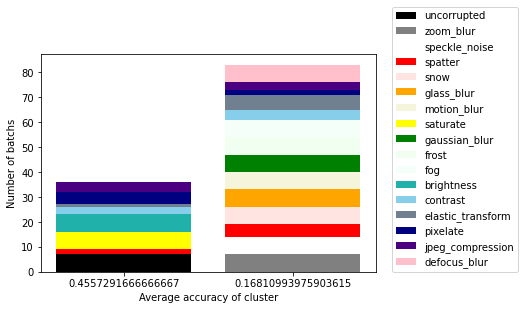

In [119]:
plot(new_cluster_sizes, clusters, accuracies, uncertainties, corruption)